<a href="https://colab.research.google.com/github/UW-CTRL/AA548-spr23/blob/main/demos/clf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import jax
import jax.numpy as jnp
from jax.typing import ArrayLike
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import cvxpy as cp
plt.style.use('seaborn-ticks')


<ipython-input-3-ab79138c4321>:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-ticks')


In [4]:
def dynamics(state: ArrayLike, control: ArrayLike) -> tuple:
    _, _, theta = state
    v, omega = control
    return jnp.array([v * jnp.cos(theta),
                      v * jnp.sin(theta),
                      omega])

def control_affine_term(state):
    _, _, theta = state
    return jnp.array([[jnp.cos(theta), 0.],
                      [jnp.sin(theta), 0.],
                      [0., 1.0]])

def rotate_vector_ccw(vector, theta):
    return jnp.array([[jnp.cos(theta), -jnp.sin(theta)],
                     [jnp.sin(theta), jnp.cos(theta)]]) @ vector

def plot_car(ax, state, car_length=0.5, car_width=0.3, color='lightskyblue', alpha=0.6):
    pos = state[:2]
    theta = state[2]
    left_corner = pos + rotate_vector_ccw(0.5 * jnp.array([-car_length, -car_width]), theta)
    car = Rectangle(left_corner, car_length, car_width, theta * 180 / jnp.pi, color=color, alpha=alpha)
    ax.add_patch(car)
    v_vector = jnp.stack([pos, pos + 3 * car_length / 4 * jnp.array([np.cos(theta), np.sin(theta)])])
    ax.plot(v_vector[:,0], v_vector[:,1])
    return ax

def plot_halfspace_lessthan(ax, a, b, c, xmin, xmax, ymin, ymax, color, alpha):
    if b == 0:
        if c == 0:
            if a < 0:
                ax.fill([-c/a, xmax, xmax, -c/a], [ymin, ymin, ymax, ymax], color=color, alpha=alpha)
            else:
                ax.fill([-c/a, xmin, xmin, -c/a], [ymin, ymin, ymax, ymax], color=color, alpha=alpha)
        else:
            if a < 0:
                ax.fill([-c/a, xmax, xmax, -c/a], [ymin, ymin, ymax, ymax], color=color, alpha=alpha)
            else:
                ax.fill([-c/a, xmin, xmin, -c/a], [ymin, ymin, ymax, ymax], color=color, alpha=alpha)
    else:
        y1 = -(a * xmin + c ) / b
        y2 = -(a * xmax + c ) / b
        if b > 0:
            plt.fill_between([xmin, xmax], [y1, y2], [ymin, ymin], color=color, alpha=alpha)
        else:
            plt.fill_between([xmin, xmax], [ymax, ymax], [y1, y2], color=color, alpha=alpha)

    return ax

    


#### Defining CLF

$V_1(x, y, \theta) = (x - x_g)^2 + (y - y_g)^2$ 

$V_2(x, y, \theta) = \left[\theta - \arctan\left( \frac{y_g - y}{x_g - x}\right)\right]^2$

In [5]:
goal_state = jnp.array([2.5, 0., 0.])

def clfs(state: ArrayLike, goal_state: ArrayLike):
    x, y, theta = state
    xg, yg, _ = goal_state
    return (x - xg)**2 + (y - yg)**2, (theta - jnp.arctan2(yg - y, xg - x))**2



In [6]:
# plotting set up
lim_value = 4
grid_points_N = 101
grid_points = jnp.linspace(-lim_value, lim_value, grid_points_N)
theta_points = jnp.linspace(-jnp.pi, jnp.pi, grid_points_N)
X, Y, THETA = jnp.meshgrid(grid_points, grid_points, theta_points)
batched_states = jnp.concatenate([X.reshape(-1,1), Y.reshape(-1,1), THETA.reshape(-1,1)], 1)
clf_values_grid = jax.vmap(clfs, [0, None])(batched_states, goal_state)
xmin = -3
xmax = 3
ymin = -3
ymax = 3


interactive(children=(FloatSlider(value=0.0, description='x', max=3.0, min=-3.0), FloatSlider(value=0.0, descr…

<function __main__.foo(x, y, theta_i)>

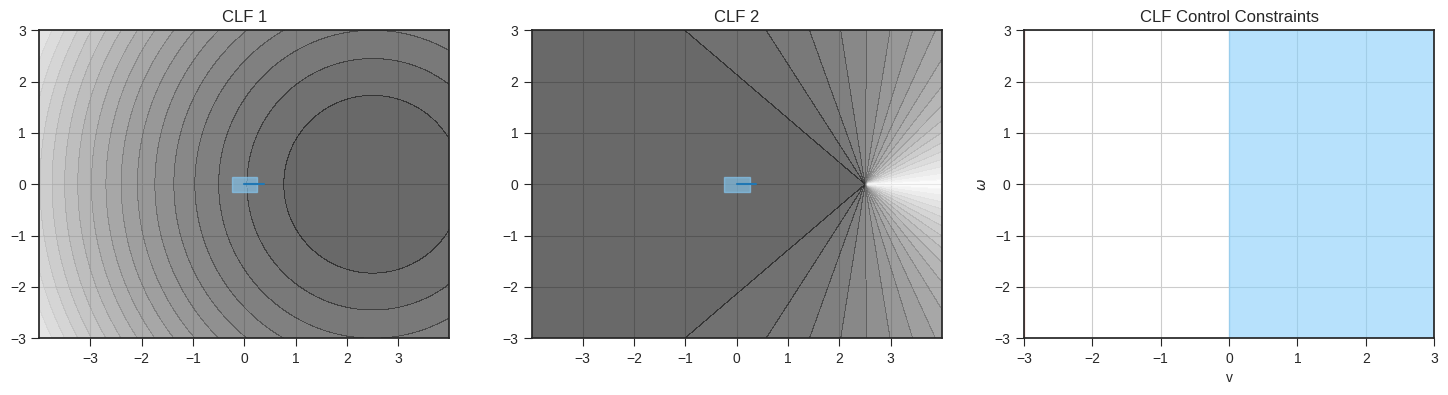

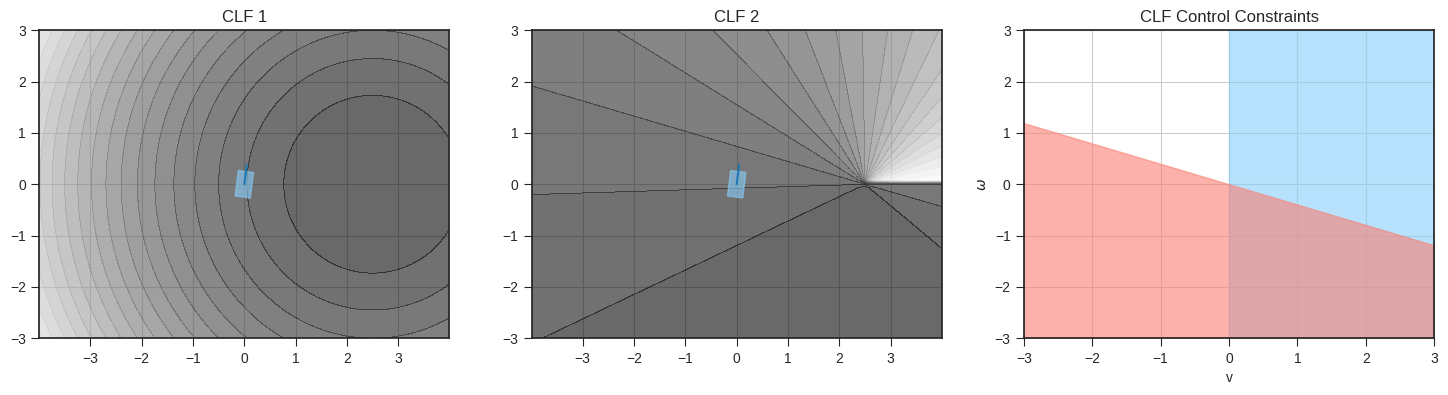

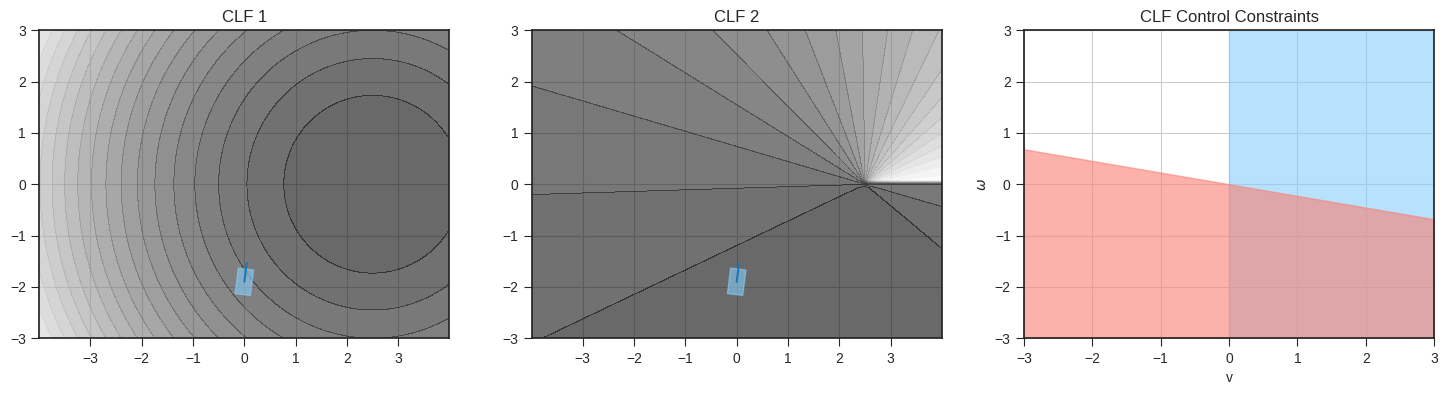

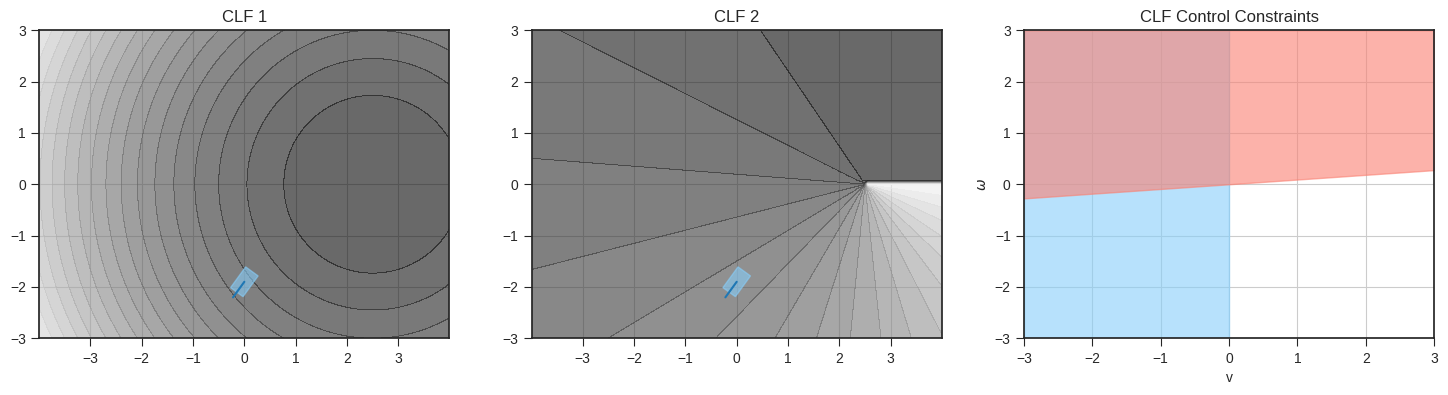

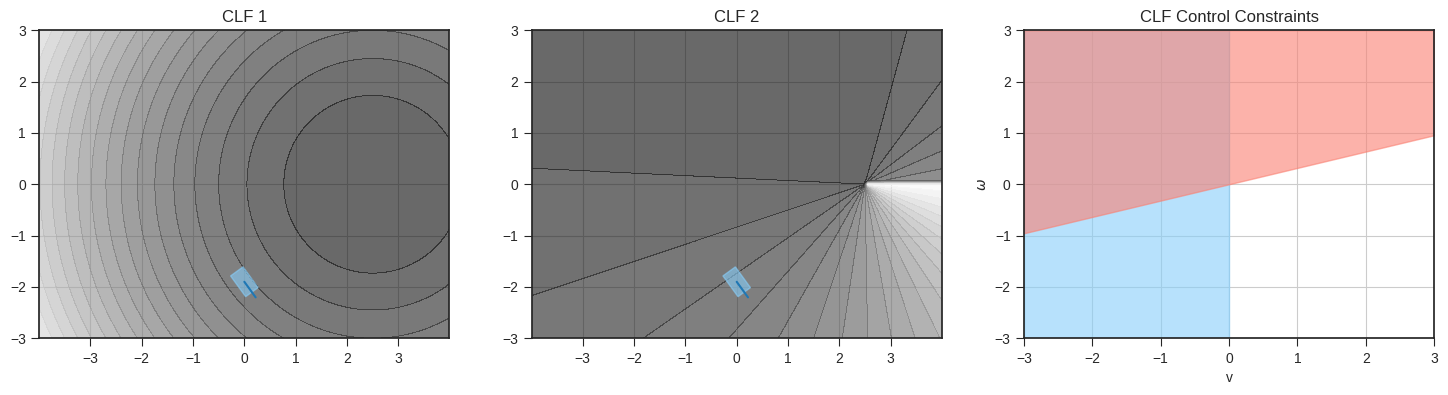

In [7]:
def foo(x, y, theta_i):
    theta = theta_points[theta_i]
    state = jnp.array([x, y, theta])
    fig, axs = plt.subplots(1,3,figsize=(18,4))
    for i in range(2):
        ax = axs[i]
        ax.contourf(X[:,:,theta_i], Y[:,:,theta_i], clf_values_grid[i].reshape(grid_points_N, grid_points_N, grid_points_N)[:,:,theta_i], 20, alpha=0.6, cmap="gist_gray")
        plot_car(ax, state)
        ax.set_title("CLF %i"%(i+1))
        ax.axis("equal")
        ax.set_xlim([xmin, xmax])
        ax.set_ylim([ymin, ymax])
        ax.grid()

    ax = axs[2]
    colors = ["lightskyblue", "salmon"]
    alpha = 0.6
    for i in range(2):
        a, b = jax.grad(lambda state: clfs(state, goal_state)[i])(state) @ control_affine_term(state)
        plot_halfspace_lessthan(ax, a, b, 0, xmin, xmax, ymin, ymax, colors[i], alpha)
    
    ax.set_title("CLF Control Constraints")
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])
    ax.grid()
    ax.set_xlabel("v")
    ax.set_ylabel("$\omega$")
    # ax.axis("equal")
    

interact(foo, x=(xmin, xmax, 0.1), 
              y=(ymin, ymax, 0.1), 
              theta_i=(0, grid_points_N-1))

### Naive (myopic) controller

$z = [x, y, \theta]^T$, $u=[v, \omega]$,  $\dot{z} = \begin{bmatrix} v\cos\theta \\ v\sin\theta \\ \omega\end{bmatrix}  = \begin{bmatrix} \cos\theta & 0 \\ \sin\theta & 0 \\ 0& 1\end{bmatrix} \begin{bmatrix} v \\ \omega\end{bmatrix}$

$$\min_{v, \omega}   \; (v - v_d)^2 + \gamma\omega^2$$
$$\text{s.t.} \; \nabla V_1(z)^T f(z, u) \leq -\beta V_1(z)$$
$$ \nabla V_2(z)^T f(z, u) \leq -\beta V_2(z)$$

In [8]:
m = 2
vd = 0.5
gamma = 0.05
beta = 0.0

u = cp.Variable(m)
dV1 = cp.Parameter(m) 
dV2 = cp.Parameter(m) 
V1 = cp.Parameter(1) 
V2 = cp.Parameter(1) 

obj = cp.Minimize( (u[0] - vd)**2 + gamma * u[1]**2)
constraints = [dV1 @ u + beta * V1 <= 0, dV2 @ u + beta * V2 <= 0]
prob = cp.Problem(obj, constraints)


In [9]:
dt = 0.1
T_max = 200

state0 = jnp.array([-3., 2., -np.pi/4])
states = [state0]
controls = []

for t in range(T_max):
    state = states[t]
    dV1.project_and_assign(jax.grad(lambda state: clfs(state, goal_state)[0])(state) @ control_affine_term(state))
    dV2.project_and_assign(jax.grad(lambda state: clfs(state, goal_state)[1])(state) @ control_affine_term(state))
    clf_value = clfs(state,  goal_state)
    if clf_value[0] < 1E-2:
        print("reached goal!!")
        break
    V1.project_and_assign(clf_value[0])
    V2.project_and_assign(clf_value[1])
    prob.solve()

    states.append(state + dynamics(state, u.value) * dt)
    controls.append(u.value)
states = jnp.stack(states)
controls = jnp.stack(controls)
clf_values = jax.vmap(clfs, [0, None])(states, goal_state)

reached goal!!


interactive(children=(IntSlider(value=99, description='t', max=199), Output()), _dom_classes=('widget-interact…

<function __main__.foo(t)>

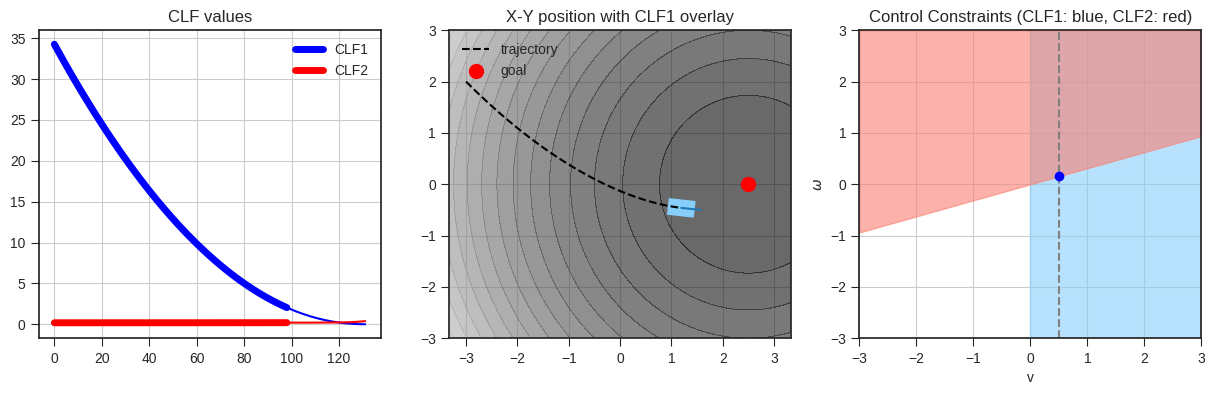

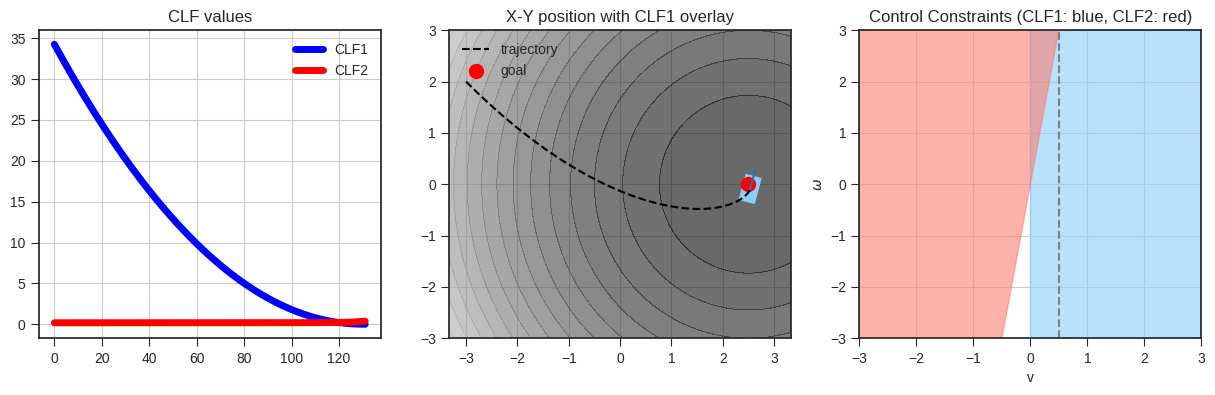

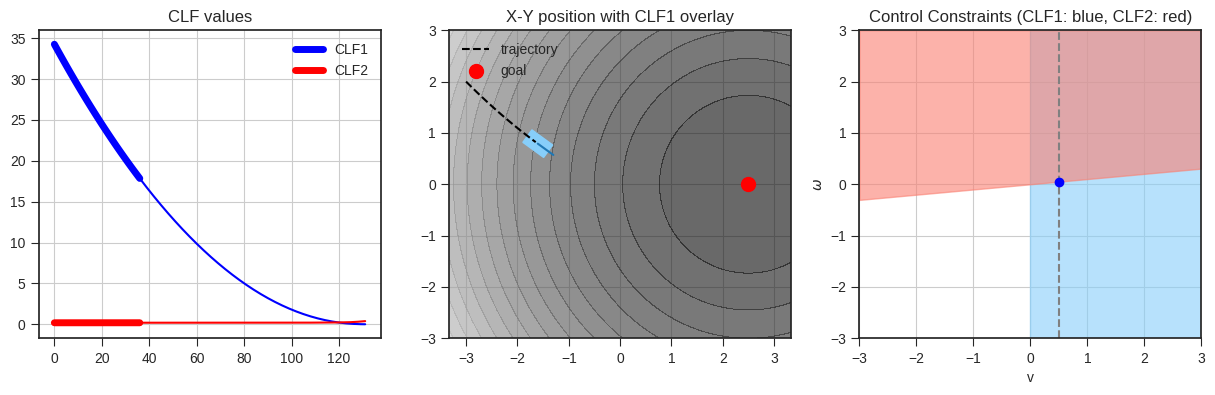

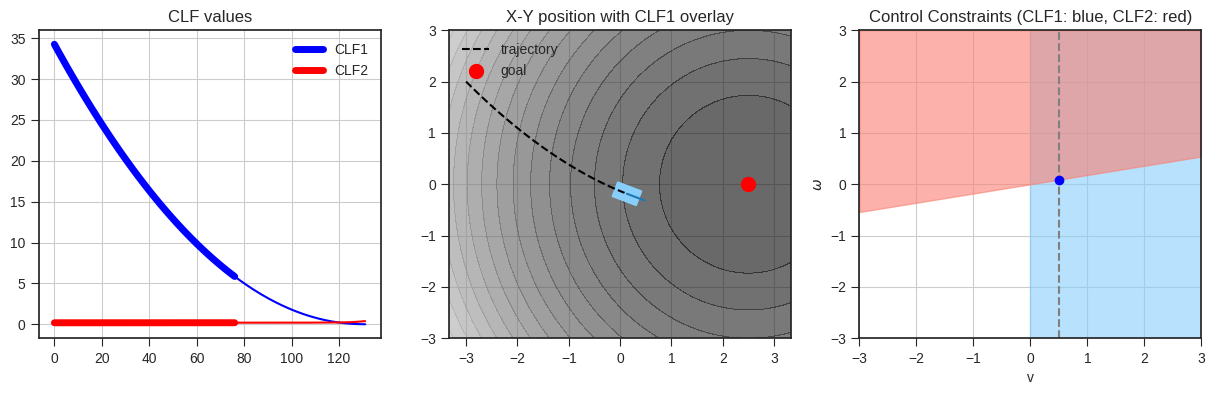

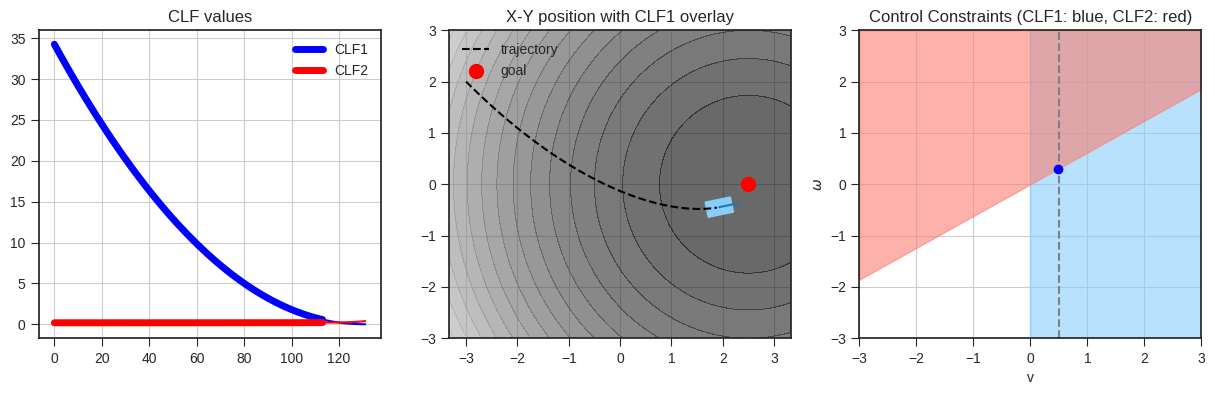

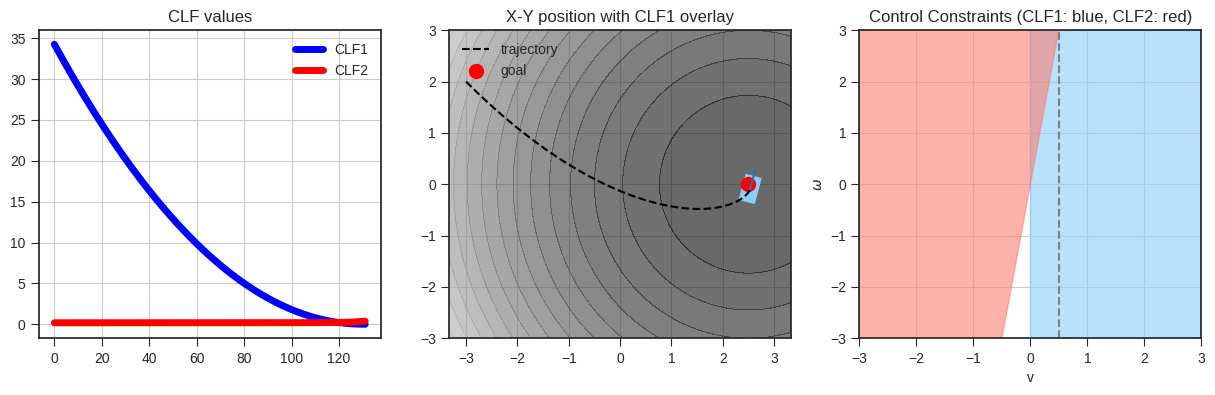

In [10]:
def foo(t):
    state = states[t]
    fig, axs = plt.subplots(1,3,figsize=(15,4))
    theta_i = 0

    ax = axs[0]
    ax.plot(clf_values[0], color="blue")
    ax.plot(clf_values[0][:t], color="blue", linewidth=5, label="CLF1")
    ax.plot(clf_values[1], color="red")
    ax.plot(clf_values[1][:t], color="red", linewidth=5, label="CLF2")
    ax.grid()
    ax.legend()
    ax.set_title("CLF values")

    ax = axs[1]
    ax.contourf(X[:,:,theta_i], Y[:,:,theta_i], clf_values_grid[0].reshape(grid_points_N, grid_points_N, grid_points_N)[:,:,theta_i], 20, alpha=0.6, cmap="gist_gray")
    plot_car(ax, state, alpha=1)
    ax.set_title("X-Y position with CLF1 overlay")
    ax.axis("equal")
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])
    ax.grid()
    ax.plot(states[:t,0], states[:t,1], color="black", linestyle="--", label="trajectory")
    ax.scatter(goal_state[:1], goal_state[1:2], s=100, color="red", label="goal")
    ax.legend(loc="upper left")


    ax = axs[2]
    colors = ["lightskyblue", "salmon"]
    alpha = 0.6
    clf_value = clfs(state,  goal_state)
    for i in range(2):
        a, b = jax.grad(lambda state: clfs(state, goal_state)[i])(state) @ control_affine_term(state)
        ax = plot_halfspace_lessthan(ax, a, b, beta * clf_value[i], xmin, xmax, ymin, ymax, colors[i], alpha)
    ax.scatter(controls[t:t+1,0], controls[t:t+1,1], color="blue", zorder=4)
    ax.axvline(vd, color="gray", linestyle="--")
    ax.set_title("Control Constraints (CLF1: blue, CLF2: red)")
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])
    ax.grid()
    ax.set_xlabel("v")
    ax.set_ylabel("$\omega$")


interact(foo, t=(0, T_max-1))

### Iterating over different values of beta

In [11]:
dt = 0.1
T_max = 200
state0 = jnp.array([-3., 2., -np.pi/4])
states_beta = []
controls_beta = []
beta_list = jnp.linspace(0.0, 1.0, 11)
for beta in beta_list:
    print("Computing for beta = %.2f"%beta)
    u = cp.Variable(m)
    dV1 = cp.Parameter(m) 
    dV2 = cp.Parameter(m) 
    V1 = cp.Parameter(1) 
    V2 = cp.Parameter(1) 
    vd = 0.5
    gamma = 0.05
    obj = cp.Minimize( (u[0] - vd)**2 + gamma * u[1]**2)
    constraints = [dV1 @ u + beta * V1 <= 0, dV2 @ u + beta * V2 <= 0]
    prob = cp.Problem(obj, constraints)
    states = [state0]
    controls = []
    for t in range(T_max):
        state = states[t]

        dV1.project_and_assign(jax.grad(lambda state: clfs(state, goal_state)[0])(state) @ control_affine_term(state))
        dV2.project_and_assign(jax.grad(lambda state: clfs(state, goal_state)[1])(state) @ control_affine_term(state))
        clf_value = clfs(state,  goal_state)
        if clf_value[0] < 1E-2:
            print("reached goal!!")
            break
        V1.project_and_assign(clf_value[0])
        V2.project_and_assign(clf_value[1])
        prob.solve()
        states.append(state + dynamics(state, u.value) * dt)
        controls.append(u.value)
    states = jnp.stack(states)
    controls = jnp.stack(controls)
    states_beta.append(states) 
    controls_beta.append(controls) 

Computing for beta = 0.00
reached goal!!
Computing for beta = 0.10
reached goal!!
Computing for beta = 0.20
reached goal!!
Computing for beta = 0.30
reached goal!!
Computing for beta = 0.40
reached goal!!
Computing for beta = 0.50
reached goal!!
Computing for beta = 0.60
reached goal!!
Computing for beta = 0.70
reached goal!!
Computing for beta = 0.80
reached goal!!
Computing for beta = 0.90
reached goal!!
Computing for beta = 1.00
reached goal!!


In [12]:
# compute CLF values for all trajectories
clf_values = [jax.vmap(clfs, [0, None])(sb, goal_state) for sb in states_beta]

interactive(children=(IntSlider(value=5, description='i', max=10), IntSlider(value=99, description='t', max=19…

<function __main__.hoo(i, t)>

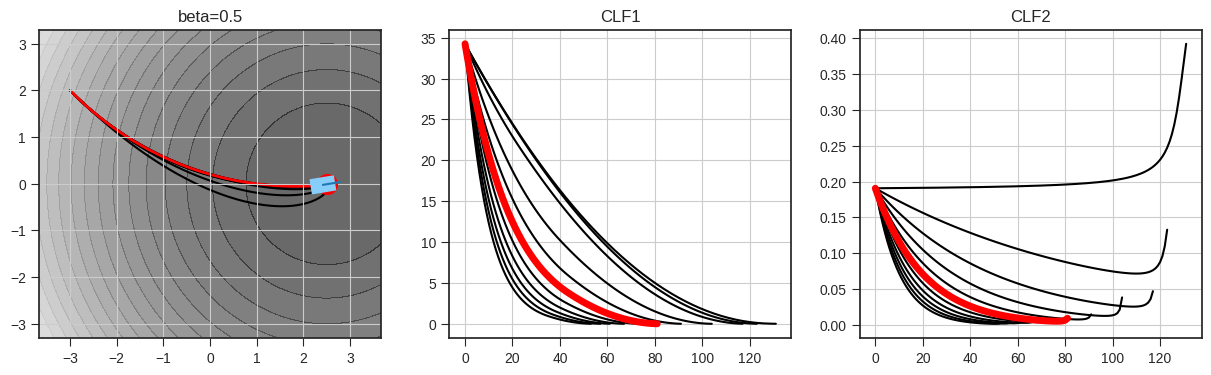

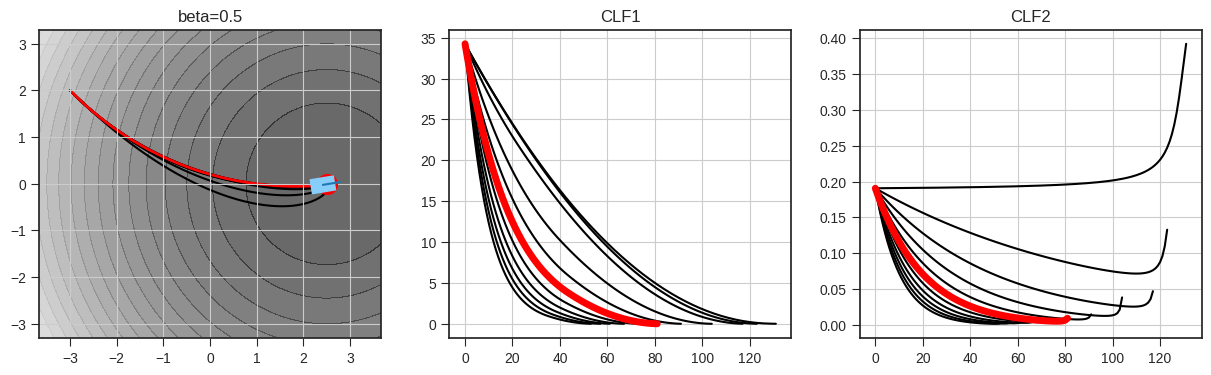

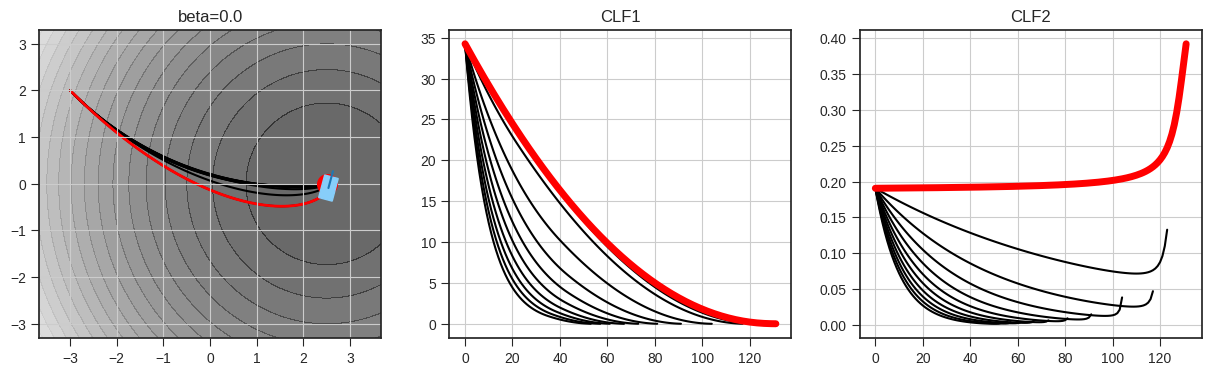

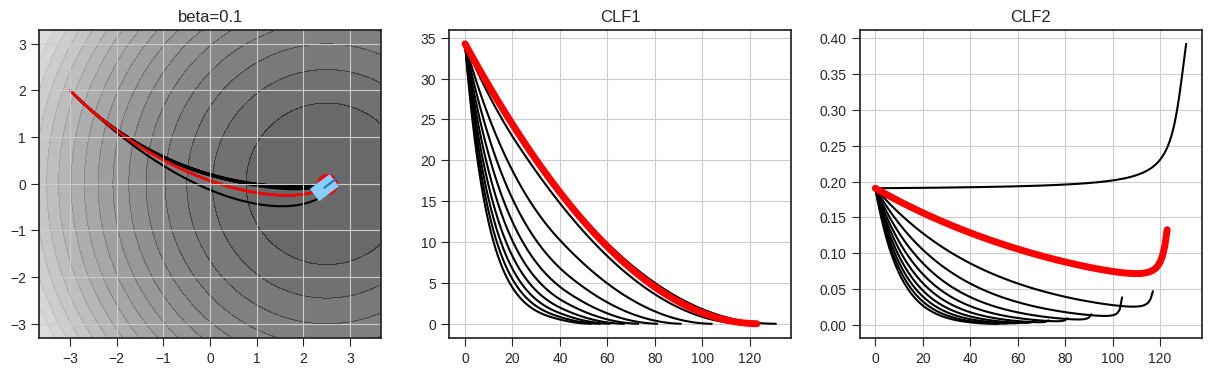

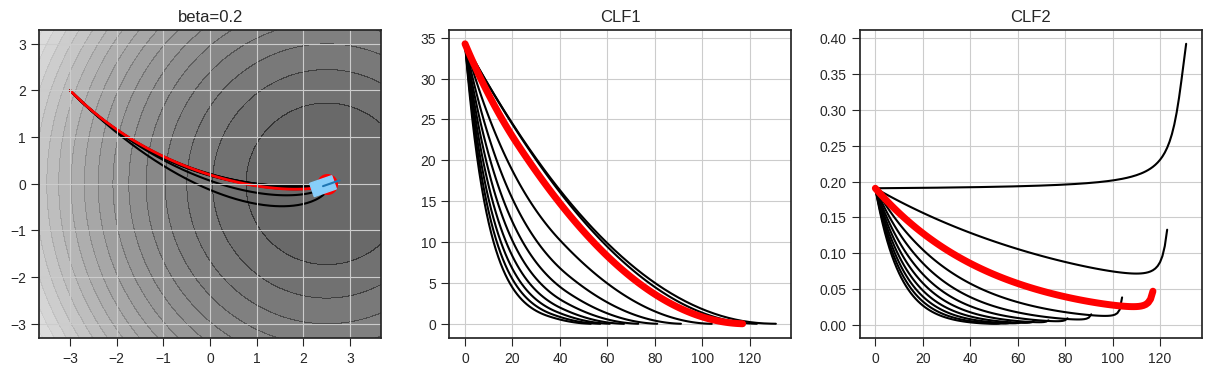

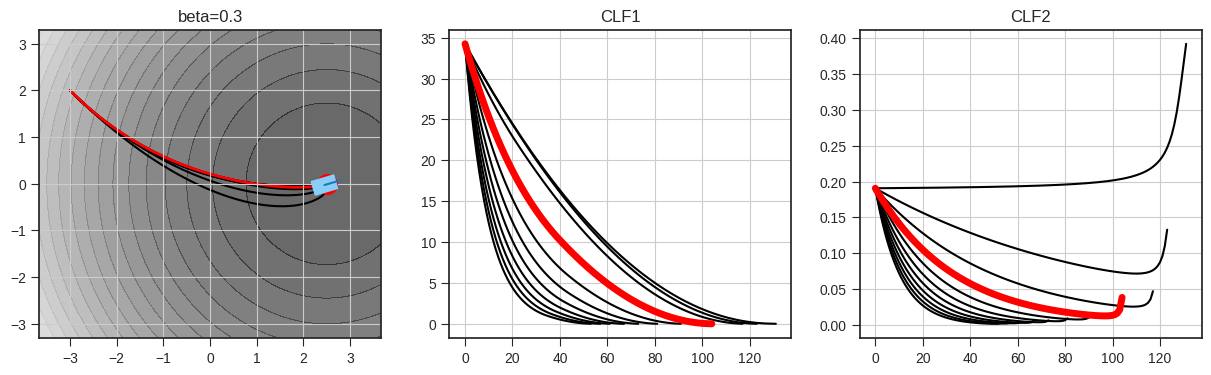

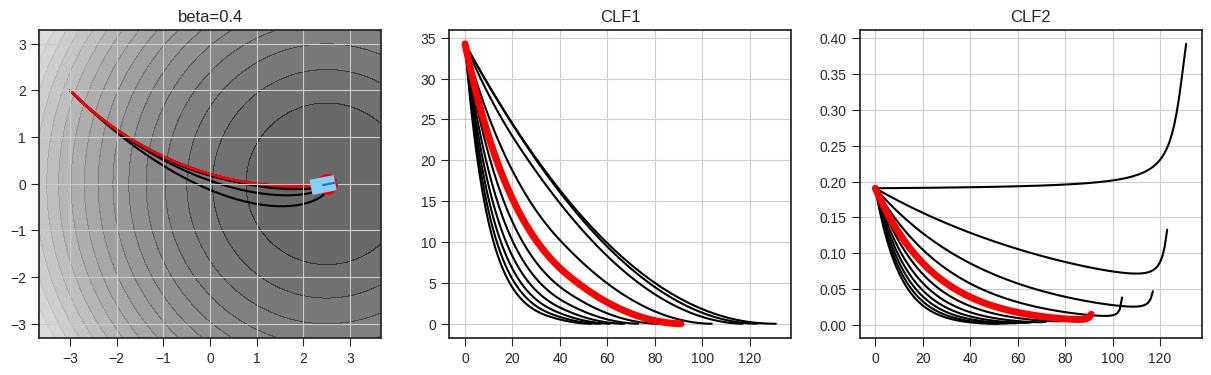

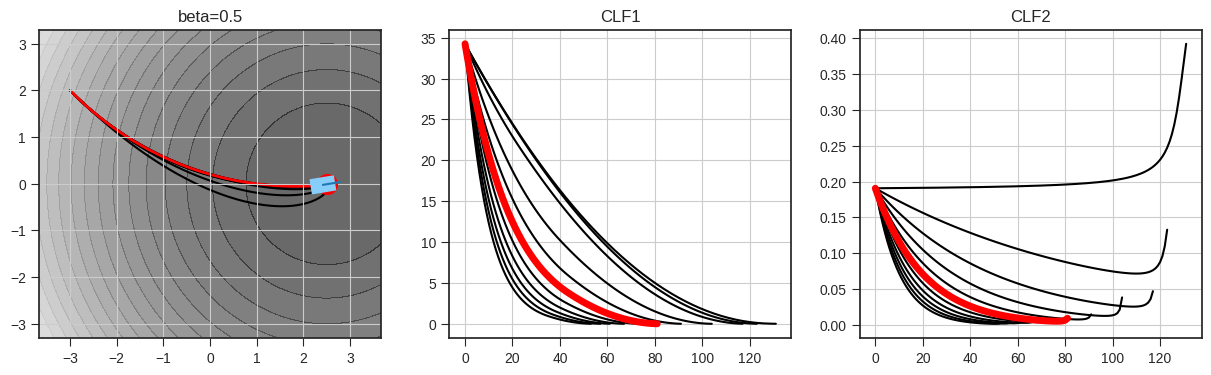

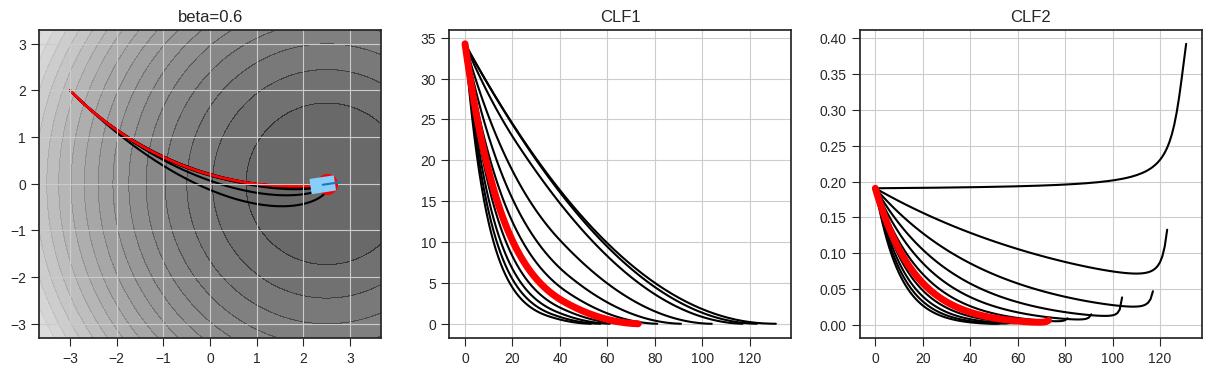

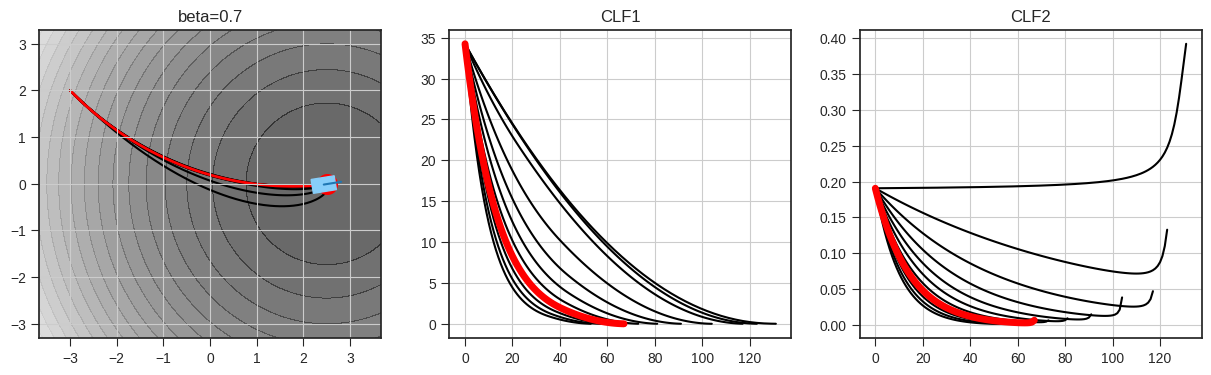

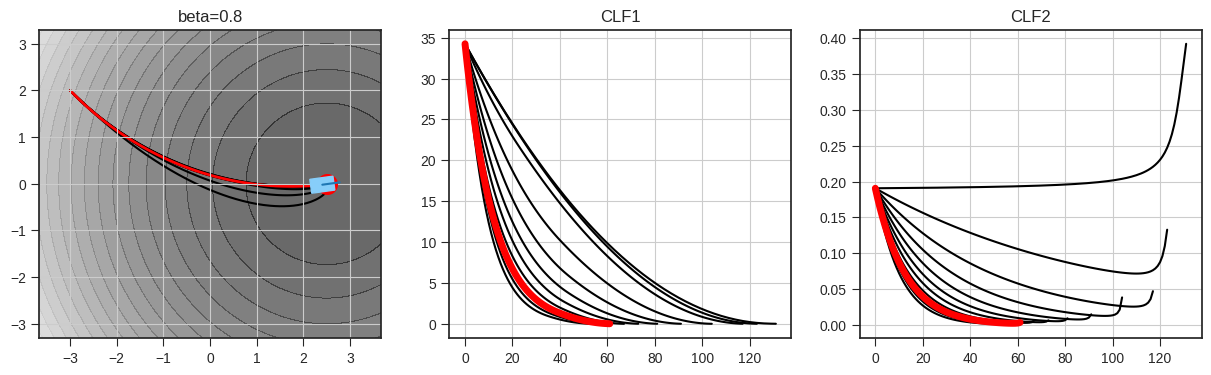

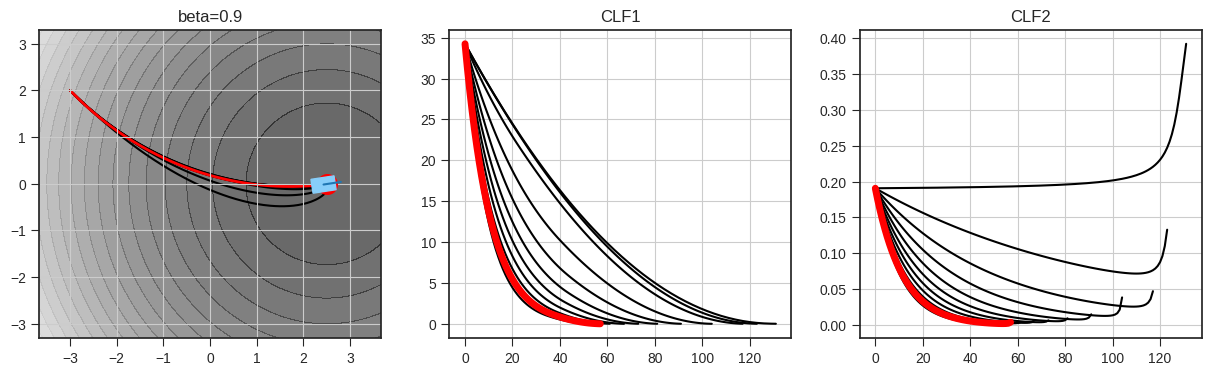

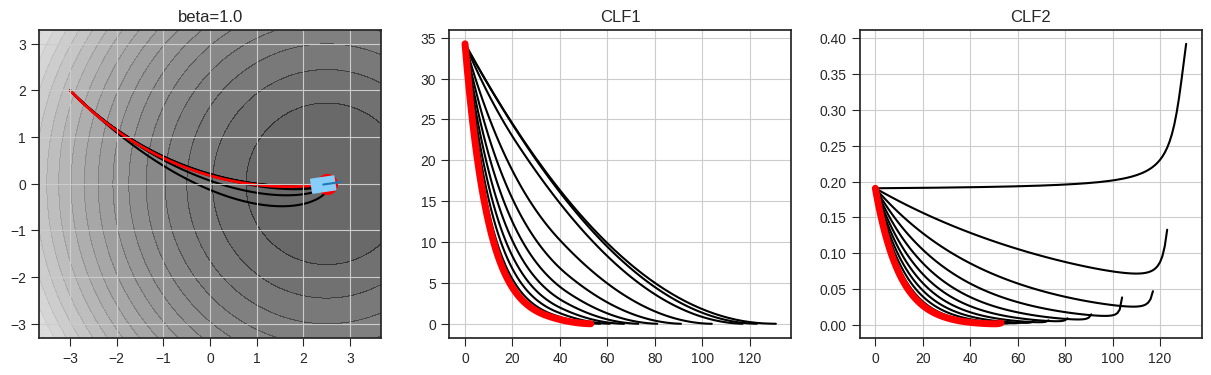

In [15]:
def hoo(i, t):
    fig, axs = plt.subplots(1,3,figsize=(15,4))
    theta_i = 0
    ax = axs[0]
    ax.contourf(X[:,:,theta_i], Y[:,:,theta_i], clf_values_grid[0].reshape(grid_points_N, grid_points_N, grid_points_N)[:,:,theta_i], 20, alpha=0.6, zorder=-5, cmap="gist_gray")
    ax.set_title("beta=%.1f"%beta_list[i])
    ax.axis("equal")
    ax.set_xlim([xmin-0.3, xmax+0.3])
    ax.set_ylim([ymin-0.3, ymax+0.3])
    ax.grid()
    for s in states_beta:
        ax.plot(s[:,0], s[:,1], color="black", zorder=-4)
        # ax.scatter(s[::5,0], s[::5,1], color="darkgray",)
    ax.scatter(goal_state[:1], goal_state[1:2], s=200, color="red")
    ax.plot(states_beta[i][:,0], states_beta[i][:,1], linewidth=2, color="red", zorder=-3)
    state = states_beta[i][t]
    plot_car(ax, state, alpha=1)

    ax = axs[1]
    [ax.plot(clf[0], color="black") for clf in clf_values]
    ax.plot(clf_values[i][0], color="red", linewidth=5)
    ax.grid()
    ax.set_title("CLF1")

    ax = axs[2]
    [ax.plot(clf[1], color="black") for clf in clf_values]
    ax.plot(clf_values[i][1], color="red", linewidth=5)
    ax.grid()
    ax.set_title("CLF2")
    # ax.set_ylim([0, 2])
    

interact(hoo, i=(0,10), t=(0, T_max-1))